### Initialize and load data

In [1]:
# Lets start by importing some basic packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
%matplotlib inline

# pynwb is for reading python NWB files
import pynwb

pd.set_option('display.max_columns', None)

In [2]:
import platform
from pathlib import Path
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = Path("/Volumes/Brain2023/")
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = Path("E:/")
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = Path("/data/")
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = Path("/media/$USERNAME/Brain2025/")

In [3]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [4]:
def extract_relevant_session_info(cache, table_type='ecephys', verbose=False):
    # table_type: 'ecephys', 'ecephys_strict', 'behavior'
    
    if table_type == 'behavior':
        session_table = cache.get_behavior_session_table() 
        session_table_final = session_table[(session_table.session_type.str.startswith('EPHYS')) & 
                                            # (behavior_session_table.genotype=='wt/wt') & ## genotypes okay for ephys
                                            (session_table.session_type.str.contains('3uL')) ## 5 uL: not motivated long enough
                                            ]
    elif 'ecephys' in table_type:
        # Filter only for mice that are (i) trained on set G, (ii) tested on first G ('familiar'), then H ('novel').
        session_table = cache.get_ecephys_session_table() 
        session_table_final = session_table[((session_table.session_type.str.startswith('EPHYS')) 
                                                # & (behavior_session_table.genotype=='wt/wt')          ## genotypes okay for ephys
                                                & (session_table.session_type.str.contains('3uL')))     ## 5 uL: not motivated long enough
                                            & ((session_table.image_set=='G') 
                                                & (session_table.experience_level=='Familiar') 
                                                & (session_table.session_number==1)) 
                                            | ((session_table.image_set=='H') 
                                                & (session_table.experience_level=='Novel') 
                                                & (session_table.session_number==2))
                                            ]
        
        if 'strict' in table_type:
            # Get mice that only have both session types
            full_session_mice_idx = np.where(session_table_final['mouse_id'].value_counts()==2)[0]
            full_session_mice     = list(session_table_final['mouse_id'].value_counts().index[full_session_mice_idx])
            session_table_final   = session_table_final[session_table_final.mouse_id.isin(full_session_mice)]
    
    if verbose:
        print(f'Unique genotypes: {session_table_final.genotype.unique()}')
        print(f'Unique session types: {session_table_final[["session_type"]].value_counts()}')
        print(f'Number of sessions: {len(session_table_final)}')
        print(f'Number of mice: {session_table_final[["mouse_id"]].value_counts()}')
        
    return session_table_final

In [ ]:
def get_perc_engaged(roll_perf, rthresh): 
    return len(roll_perf.loc[roll_perf['reward_rate']>rthresh]) / len(roll_perf)

def get_performance_summary(rolling_performance, reward_threshold=2,verbose=False):
    
    # Compute percentage spent in engaged state
    perc_engaged = get_perc_engaged(rolling_performance, reward_threshold)
    if verbose: print(f'Percentage engaged: {perc_engaged}')

    # Compute percentage spent in engaged state (before last disengagement)
    trial_last_disengagement  = rolling_performance.loc[rolling_performance['reward_rate']>reward_threshold].index[-1]+1
    # trial_first_disengagement = rolling_performance.loc[rolling_performance['reward_rate']>reward_threshold].index[0]
    perc_engaged_strict = get_perc_engaged(rolling_performance.iloc[:trial_last_disengagement], reward_threshold)
    if verbose: print(f'Percentage engaged (strict): {perc_engaged_strict}')

    performance_summary = {'perc_engaged': perc_engaged,
                            'perc_engaged_strict': perc_engaged_strict,
                            # 'trial_first_disengagement': 
                            'trial_last_disengagement': trial_last_disengagement,
                            'trial_number': len(rolling_performance)
                        }

    return performance_summary

In [ ]:
def get_performance_summary_all_sessions(cache, ecephys_session_table, reward_threshold=2, verbose=False):
    
    all_session_performance_summary = []
    for ii, session_id in enumerate(ecephys_session_table.behavior_session_id.values):

        if verbose: 
            print(f'Loading session {ii}/{len(ecephys_session_table)-1}, id: {session_id}.')

        # Load session
        session = cache.get_behavior_session(session_id)

        # Extract performance summary
        rolling_performance = session.get_rolling_performance_df()
        performance_summary = get_performance_summary(rolling_performance, reward_threshold=reward_threshold, verbose=verbose)
        performance_summary['behavior_session_id'] = session_id

        all_session_performance_summary.append(performance_summary)
    
    return all_session_performance_summary

In [ ]:
## Filter sessions based on performance metrics ##
def filter_valid_sessions(ecephys_session_table, thresh_perc_engaged = 0.6, thresh_dur_engaged = 0.6, verbose=False):
# thresh_perc_engaged = 0.6 # only sessions that have more than thresh_perc_engaged during engagement period are included in analysis [y-axis, stats 1]
# thresh_dur_engaged = 0.6 # only sessions that are engaged for longer than thresh_dur_engaged are included in analysis [x-axis, stat 2]

    ecephys_session_table['perc_last_disengagement'] = ecephys_session_table['trial_last_disengagement'] / ecephys_session_table['trial_number']

    valid_sessions = ecephys_session_table.loc[(ecephys_session_table.perc_engaged_strict > thresh_perc_engaged) \
                                                    & (ecephys_session_table.perc_last_disengagement > thresh_dur_engaged)]
    valid_session_ids = list(valid_sessions['behavior_session_id'].values)

    if verbose:
        print(f'Valid sessions ({len(valid_session_ids)})\n')
        print(valid_session_ids)

    return valid_sessions, valid_session_ids, ecephys_session_table

In [ ]:
## Plot performance metrics
def plot_performance_hist(all_session_performance_summary):
    all_perc = []
    all_perc_strict = []
    all_trial_disengage = []
    all_session_length = []
    for sess_summary in all_session_performance_summary:
        all_perc.append(sess_summary['perc_engaged'])
        all_perc_strict.append(sess_summary['perc_engaged_strict'])
        all_trial_disengage.append(sess_summary['trial_last_disengagement'])
        all_session_length.append(sess_summary['trial_number'])

    all_perc_disengage = list(np.array(all_trial_disengage) / np.array(all_session_length))

    f, axl = plt.subplots(1, 3, figsize=(12, 4))

    num_bins = 19
    all_stats       = [all_perc, all_perc_strict, all_perc_disengage]
    all_label_stats = ['% engaged / session', '% engaged / session (strict)', '% session before \n disengagement']
    all_bins        = [np.linspace(0, 1, num_bins)]*3
    filter_session  = '3*std'
    for i, (plot_stats, label_stats, bins) in enumerate(zip(all_stats, all_label_stats, all_bins)):
        ax = axl[i]
        mu = np.mean(plot_stats)
        std = np.std(plot_stats)
        ax.hist(plot_stats, bins=bins)
        ylim = ax.get_ylim()
        ax.axvline(x=mu, label=f'$\\mu$={np.round(mu,2)}, $\\sigma$={np.round(std,2)}', c='r', ls='--')
        ax.fill_betweenx(y=ylim, x1=mu-std, x2=mu+std, color='r', alpha=0.1)
        ax.set_ylim(ylim)
        ax.set_xlabel(label_stats)
        ax.set_ylabel('Count')
        ax.spines[['top','right']].set_visible(False)
        ax.legend(loc='upper left')

    f.tight_layout()

    return all_stats, all_label_stats

In [ ]:
def plot_performance_filtering(all_stats, all_label_stats, thresh_perc_engaged, thresh_dur_engaged):
    
    f, ax = plt.subplots(1,1,figsize=(4,4))
    ax.scatter(all_stats[2],all_stats[1],s=10,c=['r' if (as1 > thresh_perc_engaged and as2 > thresh_dur_engaged) else 'b' for as2, as1 in zip(all_stats[2],all_stats[1])])
    ax.axvline(x=thresh_dur_engaged, c='r', ls='--',label='threshold for inclusion')
    ax.axhline(y=thresh_perc_engaged, c='r', ls='--')
    ax.set_xlabel(all_label_stats[2])
    ax.set_ylabel(all_label_stats[1])
    ax.axhline(y=1, c='k', ls='--')
    ax.axvline(x=1, c='k', ls='--')
    ax.spines[['top','right']].set_visible(False)
    ax.legend()

    f.tight_layout()

In [ ]:
def extract_relevant_sessions(cache, valid_session_ids, verbose=False):
    all_sessions = []
    list_error = []
    for ii, session_id in enumerate(valid_session_ids):
        if verbose: 
            print(f'Start loading session {ii}/{len(valid_session_ids)}.')
        try:
            session = cache.get_behavior_session(session_id)
        except:
            list_error.append(session_id)
            continue

    df_all_sessions = pd.concat(all_sessions)
            
    return df_all_sessions, list_error

In [ ]:
def plot_single_session_performance(rolling_performance, title):
    f, ax = plt.subplots(1,1)
    ax.plot(rolling_performance['reward_rate'], 'k', label='reward rate (av. rew. / minute)')
    ax.plot(rolling_performance['hit_rate'], 'r', label='hit rate')
    ax.plot(rolling_performance['false_alarm_rate'], 'b', label='false alarm rate')
    ax.plot(rolling_performance['hit_rate'] + rolling_performance['false_alarm_rate'], 'grey', label='lick rate')
    ax.axhline(y=2,c='k', ls='--', label='Minimum reward rate')

    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Rolling rate')
    ax.spines[['top','right']].set_visible(False)
    ax.legend()
    ax.set_title(title)

In [5]:
# behavior_session_table = cache.get_behavior_session_table() #--> some ids missing here. work with ecephys_session_table.
ecephys_session_table = cache.get_ecephys_session_table() 
# probe_table = cache.get_probe_table() 
# channel_table = cache.get_channel_table() 
# unit_table = cache.get_unit_table() 

### Analyze behavior_session_table (DEPRECATED, IDs missing).

In [37]:
len(behavior_session_table)

3424

In [17]:
behavior_session_table.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN


In [18]:
behavior_session_table.session_type.unique()

array(['EPHYS_1_images_G_5uL_reward', 'EPHYS_1_images_H_5uL_reward',
       'EPHYS_1_images_G_3uL_reward', 'EPHYS_1_images_H_3uL_reward'],
      dtype=object)

In [24]:
# Filter session types: only include ephys
behavior_session_table_ephys = behavior_session_table[behavior_session_table.session_type.str.startswith('EPHYS')]
behavior_session_table_ephys.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN


In [25]:
behavior_session_table_ephys.session_type.unique()

array(['EPHYS_1_images_G_3uL_reward', 'EPHYS_1_images_H_3uL_reward',
       'EPHYS_1_images_G_5uL_reward', 'EPHYS_1_images_H_5uL_reward'],
      dtype=object)

In [28]:
behavior_session_table_ephys[['session_type']].value_counts()

session_type               
EPHYS_1_images_G_3uL_reward    77
EPHYS_1_images_H_3uL_reward    77
EPHYS_1_images_G_5uL_reward     4
EPHYS_1_images_H_5uL_reward     4
dtype: int64

In [30]:
behavior_session_table_final = behavior_session_table_ephys[behavior_session_table_ephys.session_type.str.contains('3uL')]
behavior_session_table_final.session_type.unique()

array(['EPHYS_1_images_G_3uL_reward', 'EPHYS_1_images_H_3uL_reward'],
      dtype=object)

In [31]:
behavior_session_table_final.head()

,equipment_name,genotype,mouse_id,sex,age_in_days,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ecephys_session_id,date_of_acquisition,session_type,image_set,file_id
behavior_session_id,,,,,,,,,,,,,,
1050987699,NP.1,wt/wt,524760,F,179,57,0,51,0,1050962145,2020-09-16 16:11:51.118000+00:00,EPHYS_1_images_G_3uL_reward,G,1288
1071409009,NP.0,wt/wt,544835,M,146,43,0,0,1,1071301976,2020-12-17 14:47:15.831000+00:00,EPHYS_1_images_H_3uL_reward,H,2104
1071005395,NP.1,wt/wt,548465,M,123,36,0,26,0,1070969560,2020-12-16 14:20:05.950000+00:00,EPHYS_1_images_G_3uL_reward,G,2271
1067611876,NP.1,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,546512,M,119,27,0,19,0,1067593545,2020-12-02 14:25:23.075000+00:00,EPHYS_1_images_G_3uL_reward,G,2309
1077916733,NP.0,wt/wt,548715,F,157,33,0,0,1,1077891954,2021-01-21 14:14:08.361000+00:00,EPHYS_1_images_H_3uL_reward,H,2480


In [35]:
behavior_session_table_final = behavior_session_table_final[behavior_session_table_final.genotype=='wt/wt']
print(behavior_session_table_final.genotype.unique())
print(len(behavior_session_table_final))
print(behavior_session_table_final[['session_type']].value_counts())

['wt/wt']
52
session_type               
EPHYS_1_images_G_3uL_reward    26
EPHYS_1_images_H_3uL_reward    26
dtype: int64


### Analyze ecephys_session_table

In [38]:
len(ecephys_session_table)

103

In [39]:
ecephys_session_table.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN


In [48]:
ecephys_session_table.groupby(['image_set','experience_level','session_number']).count()

behavior_session_id  \
image_set experience_level session_number                        
G         Familiar         1                                38   
                           2                                 3   
          Novel            2                                10   
H         Familiar         1                                10   
          Novel            1                                 3   
                           2                                39   

                                           date_of_acquisition  \
image_set experience_level session_number                        
G         Familiar         1                                38   
                           2                                 3   
          Novel            2                                10   
H         Familiar         1                                10   
          Novel            1                                 3   
                           2                                39   

                                           equipment_name  session_type  \
image_set experience_level session_number                                 
G         Familiar         1                           38            38   
                           2                            3             3   
          Novel            2                           10            10   
H         Familiar         1                           10            10   
          Novel            1                            3             3   
                           2                           39            39   

                                           mouse_id  genotype  sex  \
image_set experience_level session_number                            
G         Familiar         1                     38        38   38   
                           2                      3         3    3   
          Novel            2                     10        10   10   
H         Familiar         1                     10        10   10   
          Novel            1                      3         3    3   
                           2                     39        39   39   

                                           project_code  age_in_days  \
image_set experience_level session_number                              
G         Familiar         1                         38           38   
                           2                          3            3   
          Novel            2                         10           10   
H         Familiar         1                         10           10   
          Novel            1                          3            3   
                           2                         39           39   

                                           unit_count  probe_count  \
image_set experience_level session_number                            
G         Familiar         1                       38           38   
                           2                        3            3   
          Novel            2                       10           10   
H         Familiar         1                       10           10   
          Novel            1                        3            3   
                           2                       39           39   

                                           channel_count  structure_acronyms  \
image_set experience_level session_number                                      
G         Familiar         1                          38                  38   
                           2                           3                   3   
          Novel            2                          10                  10   
H         Familiar         1                          10                  10   
          Novel            1                           3                   3   
                           2                          39                  39   

                                           p

In [51]:
# Filter only for mice that are (i) trained on set G, (ii) tested on first G ('familiar'), then H ('novel').
ecephys_session_table_filtered = ecephys_session_table[((ecephys_session_table.image_set=='G') 
                      & (ecephys_session_table.experience_level=='Familiar') 
                      & (ecephys_session_table.session_number==1)) 
                      | ((ecephys_session_table.image_set=='H') 
                      & (ecephys_session_table.experience_level=='Novel') 
                      & (ecephys_session_table.session_number==2))]
len(ecephys_session_table_filtered)

77

In [52]:
ecephys_session_table_filtered.groupby(['image_set','experience_level','session_number']).count()

,,,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,prior_exposures_to_image_set,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
image_set,experience_level,session_number,,,,,,,,,,,,,,,,,,
G,Familiar,1,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,0,0
H,Novel,2,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,0,0


In [65]:
single_session_mice_idx = np.where(ecephys_session_table_filtered['mouse_id'].value_counts()==1)[0]

single_session_mice = list(ecephys_session_table_filtered['mouse_id'].value_counts().index[single_session_mice_idx])
ecephys_session_table_filtered2 = ecephys_session_table_filtered.loc[ecephys_session_table_filtered.mouse_id.isin(single_session_mice)]

ecephys_session_table_filtered2

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1051155866,1052162536,2020-09-17 15:05:39.665000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,524760,wt/wt,F,NeuropixelVisualBehavior,180,1922,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,883,NaN,NaN
1069461581,1069518782,2020-12-10 14:04:24.701000+00:00,NP.0,EPHYS_1_images_H_3uL_reward,545994,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,131,1886,6,2304,"['grey', 'root', 'VISal', 'VISam', 'VISl', 'VI...",H,0,2,Novel,1,920,NaN,NaN
1071300149,1071409007,2020-12-17 14:59:40.168000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,548465,wt/wt,M,NeuropixelVisualBehavior,124,1802,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,922,NaN,NaN
1089296550,1089343256,2021-03-10 14:24:06.841000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,556016,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,156,3012,6,2304,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",G,21,1,Familiar,0,950,NaN,NaN
1098119201,1098148095,2021-04-21 14:34:29.474000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,563323,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,140,2679,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,24,1,Familiar,0,964,NaN,NaN


### Check single relevant session to understand filtering of metrics

In [6]:
ecephys_session_table_final = extract_relevant_session_info(cache, table_type='ecephys', verbose=False)
len(ecephys_session_table_final)

77

In [7]:
ecephys_session_table_final.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103,5,1920,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN


In [10]:
## Check single session to determine filtering
test_session_id = ecephys_session_table_final.iloc[0]['behavior_session_id']
print(test_session_id)
test_session = cache.get_behavior_session(test_session_id)

1044408432


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [15]:
test_session.list_data_attributes_and_methods()

['behavior_session_id',
 'eye_tracking',
 'eye_tracking_rig_geometry',
 'get_performance_metrics',
 'get_reward_rate',
 'get_rolling_performance_df',
 'licks',
 'metadata',
 'raw_running_speed',
 'rewards',
 'running_speed',
 'stimulus_presentations',
 'stimulus_templates',
 'stimulus_timestamps',
 'task_parameters',
 'trials']

In [19]:
performance_metrics = test_session.get_performance_metrics()
performance_metrics

{'trial_count': 669,
 'go_trial_count': 239,
 'catch_trial_count': 35,
 'hit_trial_count': 124,
 'miss_trial_count': 115,
 'false_alarm_trial_count': 5,
 'correct_reject_trial_count': 30,
 'auto_reward_count': 3,
 'earned_reward_count': 124,
 'total_reward_count': 127,
 'total_reward_volume': 0.635,
 'maximum_reward_rate': 3.688587956275341,
 'engaged_trial_count': 412,
 'mean_hit_rate': 0.5945527422420802,
 'mean_hit_rate_uncorrected': 0.5963775597603284,
 'mean_hit_rate_engaged': 0.706397004255107,
 'mean_false_alarm_rate': 0.22863698030364696,
 'mean_false_alarm_rate_uncorrected': 0.20070148986815656,
 'mean_false_alarm_rate_engaged': 0.3008317744894926,
 'mean_dprime': 1.098278136723945,
 'mean_dprime_engaged': 1.1263622032520146,
 'max_dprime': 1.8823365005969235,
 'max_dprime_engaged': 1.8823365005969235}

#### Understanding trial types

In [26]:
# Check if performance types (for go trials) match the number of go/catch trials
np.sum([performance_metrics[tt_type] for tt_type in ['hit_trial_count',
                                                    'miss_trial_count',
                                                    'false_alarm_trial_count',
                                                    'correct_reject_trial_count']]) \
    == np.sum([performance_metrics[tt_type] for tt_type in ['go_trial_count',
                                                            'catch_trial_count']])

# Note: total number of trials also includes the aborted trials (go / catch trials are a subset of these) -- see visualization below

True

In [54]:
# Detailed view of the trials
trials = test_session.trials
trials

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
0,26.19930,27.33304,im036_r,im036_r,False,NaN,False,False,"[26.54901, 26.84878, 27.01597]",NaN,NaN,0.000,False,False,False,False,True,False,-99,1.13374
1,27.70000,36.47409,im036_r,im111_r,True,32.20433,False,False,"[32.73711, 32.93716, 33.05433, 33.15406, 33.28...",32.73711,32.35446,0.005,False,False,False,False,False,True,420,8.77409
2,36.70751,37.49146,im111_r,im111_r,False,NaN,False,False,[37.19112],NaN,NaN,0.000,False,False,False,False,True,False,-99,0.78395
3,38.20902,41.12808,im111_r,im111_r,False,NaN,False,False,[40.81084],NaN,NaN,0.000,False,False,False,False,True,False,-99,2.91906
4,41.21145,48.50069,im111_r,im012_r,True,44.21435,False,False,"[44.64699, 44.73036, 44.83042, 44.94718, 45.36...",44.64699,44.38143,0.005,False,False,False,False,False,True,1140,7.28924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,3586.37764,3597.40359,im047_r,im078_r,True,3593.13361,True,False,"[3593.55081, 3593.76669]",3593.55081,3593.55081,0.005,True,False,False,False,False,False,213894,11.02595
665,3597.63695,3604.91015,im078_r,im078_r,False,3600.63994,False,True,[3602.85766],3602.85766,NaN,0.000,False,False,False,True,False,False,214344,7.27320
666,3605.14325,3614.66805,im078_r,im012_r,True,3610.39835,True,False,[],NaN,NaN,0.000,False,False,True,False,False,False,214929,9.52480


In [55]:
trials_filtered = trials.loc[trials.is_change]
trials_filtered

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
1,27.70000,36.47409,im036_r,im111_r,True,32.20433,False,False,"[32.73711, 32.93716, 33.05433, 33.15406, 33.28...",32.73711,32.35446,0.005,False,False,False,False,False,True,420,8.77409
4,41.21145,48.50069,im111_r,im012_r,True,44.21435,False,False,"[44.64699, 44.73036, 44.83042, 44.94718, 45.36...",44.64699,44.38143,0.005,False,False,False,False,False,True,1140,7.28924
5,48.71739,57.47513,im012_r,im083_r,True,53.22190,False,False,"[53.63786, 53.72121, 53.8213, 53.9381, 54.0381...",53.63786,53.37205,0.005,False,False,False,False,False,True,1680,8.75774
10,74.23906,86.03217,im083_r,im078_r,True,81.74545,True,False,"[82.21292, 82.56205, 82.67919, 82.77881, 83.12...",82.21292,82.21292,0.005,True,False,False,False,False,False,3390,11.79311
11,86.24906,93.50500,im078_r,im111_r,True,89.25177,True,False,"[90.08505, 90.202, 90.3518, 90.46882, 90.61867...",90.08505,NaN,0.000,False,False,True,False,False,False,3840,7.25594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,3568.36242,3575.63547,im044_r,im047_r,True,3571.36547,True,False,[],NaN,NaN,0.000,False,False,True,False,False,False,212589,7.27305
664,3586.37764,3597.40359,im047_r,im078_r,True,3593.13361,True,False,"[3593.55081, 3593.76669]",3593.55081,3593.55081,0.005,True,False,False,False,False,False,213894,11.02595
666,3605.14325,3614.66805,im078_r,im012_r,True,3610.39835,True,False,[],NaN,NaN,0.000,False,False,True,False,False,False,214929,9.52480


In [37]:
trials[['initial_image_name']].value_counts()

initial_image_name
im078_r               98
im012_r               88
im047_r               87
im044_r               86
im111_r               86
im115_r               81
im036_r               72
im083_r               71
dtype: int64

In [38]:
trials[['change_image_name']].value_counts()

change_image_name
im078_r              98
im012_r              88
im047_r              87
im044_r              86
im111_r              86
im115_r              82
im036_r              71
im083_r              71
dtype: int64

In [69]:
print(trials[['go','catch','aborted']].value_counts().sum())
trials[['go','catch','aborted']].value_counts()

# It seems that there are 4 types of trials -- the remaining 3 trials are the initial 'auto_reward_trials' (used for initial satiation of the mice, always 3)

669


go     catch  aborted
False  False  True       392
True   False  False      239
False  True   False       35
       False  False        3
dtype: int64

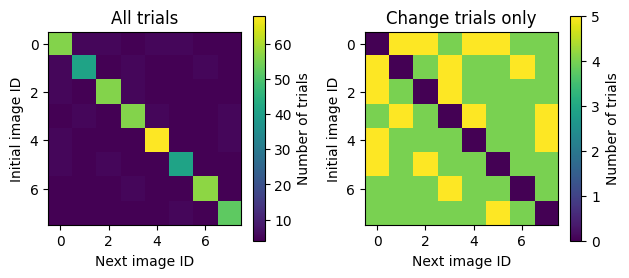

In [71]:
# Create matrix with trial types (number = color)
filter_aborted = False

if filter_aborted:
    plot_trials = trials.loc[trials.aborted==False]
    plot_trials_filtered = trials_filtered.loc[trials_filtered.aborted==False]
else:
    plot_trials = trials
    plot_trials_filtered = trials_filtered
crosstab = pd.crosstab(plot_trials['initial_image_name'], plot_trials['change_image_name'])
crosstab_filter = pd.crosstab(plot_trials_filtered['initial_image_name'], plot_trials_filtered['change_image_name'])

f,axl = plt.subplots(1,2)
ax = axl[0]
a1 = ax.imshow(np.array(crosstab),aspect='equal',cmap='viridis')
ax.set_xlabel('Next image ID')
ax.set_ylabel('Initial image ID')
f.colorbar(a1, label='Number of trials', shrink=0.5)
ax.set_title('All trials')

ax = axl[1]
a2 = ax.imshow(np.array(crosstab_filter),aspect='equal',cmap='viridis')
ax.set_xlabel('Next image ID')
ax.set_ylabel('Initial image ID')
f.colorbar(a2, label='Number of trials', shrink=0.5)
ax.set_title('Change trials only')

f.tight_layout()

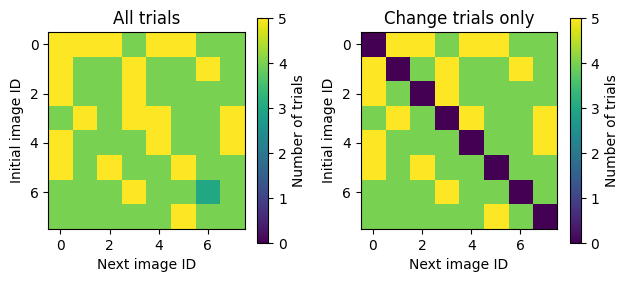

In [72]:
# Create matrix with trial types (number = color)
filter_aborted = True

if filter_aborted:
    plot_trials = trials.loc[trials.aborted==False]
    plot_trials_filtered = trials_filtered.loc[trials_filtered.aborted==False]
else:
    plot_trials = trials
    plot_trials_filtered = trials_filtered
crosstab = pd.crosstab(plot_trials['initial_image_name'], plot_trials['change_image_name'])
crosstab_filter = pd.crosstab(plot_trials_filtered['initial_image_name'], plot_trials_filtered['change_image_name'])

f,axl = plt.subplots(1,2)
ax = axl[0]
a1 = ax.imshow(np.array(crosstab),aspect='equal',cmap='viridis',vmin=0,vmax=5)
ax.set_xlabel('Next image ID')
ax.set_ylabel('Initial image ID')
f.colorbar(a1, label='Number of trials', shrink=0.5)
ax.set_title('All trials')

ax = axl[1]
a2 = ax.imshow(np.array(crosstab_filter),aspect='equal',cmap='viridis',vmin=0,vmax=5)
ax.set_xlabel('Next image ID')
ax.set_ylabel('Initial image ID')
f.colorbar(a2, label='Number of trials', shrink=0.5)
ax.set_title('Change trials only')

f.tight_layout()

#### Understanding performance metrics

In [76]:
rolling_performance = test_session.get_rolling_performance_df()
rolling_performance

,reward_rate,hit_rate_raw,hit_rate,false_alarm_rate_raw,false_alarm_rate,rolling_dprime
trials_id,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
664,0.768534,0.252874,0.252874,0.0,0.038462,1.103351
665,0.804636,0.255814,0.255814,0.0,0.035714,1.146438
666,0.838394,0.252874,0.252874,0.0,0.038462,1.103351


In [77]:
np.where(~np.isnan(rolling_performance['reward_rate']))[0][0]

10

In [87]:
rolling_performance

,reward_rate,hit_rate_raw,hit_rate,false_alarm_rate_raw,false_alarm_rate,rolling_dprime
trials_id,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
664,0.768534,0.252874,0.252874,0.0,0.038462,1.103351
665,0.804636,0.255814,0.255814,0.0,0.035714,1.146438
666,0.838394,0.252874,0.252874,0.0,0.038462,1.103351


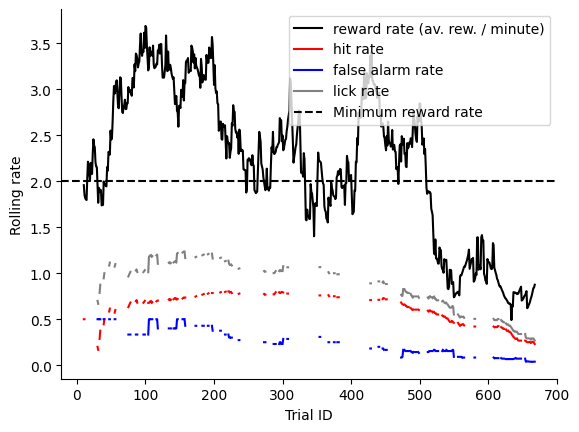

In [90]:
f, ax = plt.subplots(1,1)
ax.plot(rolling_performance['reward_rate'], 'k', label='reward rate (av. rew. / minute)')
ax.plot(rolling_performance['hit_rate'], 'r', label='hit rate')
ax.plot(rolling_performance['false_alarm_rate'], 'b', label='false alarm rate')
ax.plot(rolling_performance['hit_rate'] + rolling_performance['false_alarm_rate'], 'grey', label='lick rate')
ax.axhline(y=2,c='k', ls='--', label='Minimum reward rate')

ax.set_xlabel('Trial ID')
ax.set_ylabel('Rolling rate')
ax.spines[['top','right']].set_visible(False)
ax.legend()

### Performance metrics distributions over sessions

In [65]:
## Complete workflow ##
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Extract relevant sessions based on task structure (ephys, 3uL, trained on G, familiar session first)
ecephys_session_table_final = extract_relevant_session_info(cache, table_type='ecephys_strict', verbose=True)
# For debugging: reduce table
# ecephys_session_table_final = ecephys_session_table_final.iloc[:10]
# ecephys_session_table_final.head()

print(f'Number of sessions included in distribution: {len(ecephys_session_table_final)}')

# Extract performance metrics for relevant sessions 
all_session_performance_summary = get_performance_summary_all_sessions(cache, ecephys_session_table_final, reward_threshold=2, verbose=True)

Unique genotypes: ['Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'
 'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt' 'wt/wt']
Unique session types: session_type               
EPHYS_1_images_G_3uL_reward    35
EPHYS_1_images_H_3uL_reward    35
dtype: int64
Number of sessions: 70
Number of mice: mouse_id
509808      2
567286      2
556014      2
558306      2
560356      2
560770      2
560771      2
563497      2
568963      2
554013      2
570299      2
570301      2
572846      2
574078      2
574081      2
574082      2
555304      2
553960      2
521466      2
536480      2
524925      2
527749      2
530862      2
532246      2
533537      2
533539      2
541234      2
553253      2
544358      2
544456      2
544836      2
544838      2
548720      2
548721      2
599294      2
dtype: int64
Number of sessions included in distribution: 70
Loading session 0/69, id: 1048005547.
Percentage engaged: 0.9803600654664485
Percentage engaged (strict): 0.9803600654664485
Loading session 1/69

In [67]:
len(all_session_performance_summary)

70

In [68]:
## Merge with session table
df_all_session_performance_summary = pd.DataFrame(all_session_performance_summary)
ecephys_session_table_final = ecephys_session_table_final.reset_index()
ecephys_session_table_final2 = ecephys_session_table_final.merge(df_all_session_performance_summary, on=['behavior_session_id'])
ecephys_session_table_final2.head()

,ecephys_session_id,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity,perc_engaged,perc_engaged_strict,trial_last_disengagement,trial_number
0,1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62,1,Familiar,0,877,NaN,NaN,0.980360,0.980360,611,611
1,1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51,1,Familiar,0,878,NaN,NaN,0.696113,0.975248,404,566
2,1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN,0.395122,0.437050,556,615
3,1048196054,1048222325,2020-09-03 14:25:07.290000+00:00,NP.0,EPHYS_1_images_H_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,166,2288,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,880,NaN,NaN,0.802583,0.947712,459,542
4,1049273528,1049299003,2020-09-09 15:04:23.986000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,521466,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,193,2165,6,2304,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,56,1,Familiar,0,881,NaN,NaN,0.899110,0.899110,674,674


In [69]:
# Filter sessions based on performance
thresh_perc_engaged = 0.6; thresh_dur_engaged = 0.6
valid_sessions, valid_session_ids, _ = filter_valid_sessions(ecephys_session_table_final2, thresh_perc_engaged = thresh_perc_engaged, thresh_dur_engaged = thresh_dur_engaged, verbose=True)

Valid sessions (61)

[1048005547, 1048009327, 1048222325, 1049299003, 1049542142, 1052374521, 1052572359, 1053759575, 1053759573, 1053960984, 1053960987, 1055253879, 1055260435, 1055431030, 1055434752, 1062781531, 1063068136, 1064445631, 1064668541, 1065499125, 1065491938, 1065929713, 1065927708, 1067611872, 1067817036, 1081118392, 1081125370, 1081474898, 1081469485, 1086220230, 1086446431, 1087742174, 1090830527, 1091068323, 1091070296, 1092312238, 1092494311, 1093668878, 1093670602, 1093938328, 1093935326, 1095177109, 1095376453, 1096694612, 1104103368, 1104327081, 1105594809, 1108567373, 1111047108, 1111250074, 1112334683, 1112548552, 1115115786, 1115115784, 1090829963, 1115423017, 1115431348, 1118614693, 1121438973, 1152646832, 1152845816]


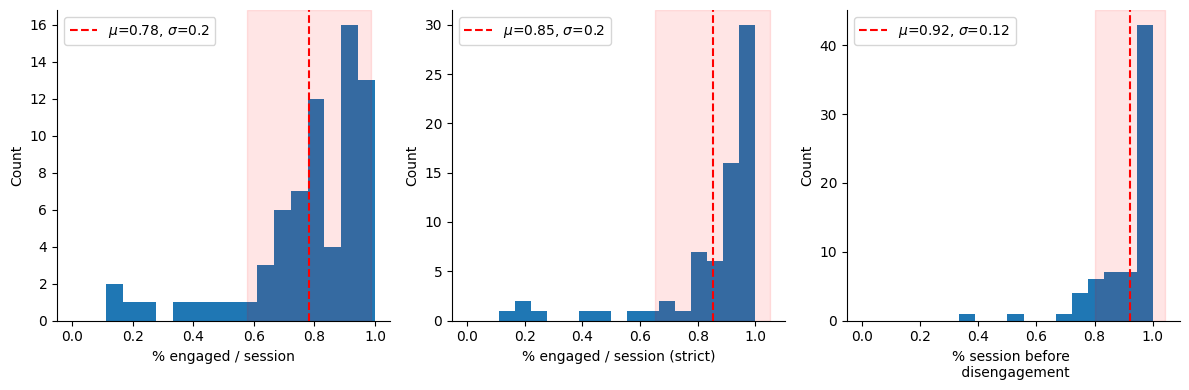

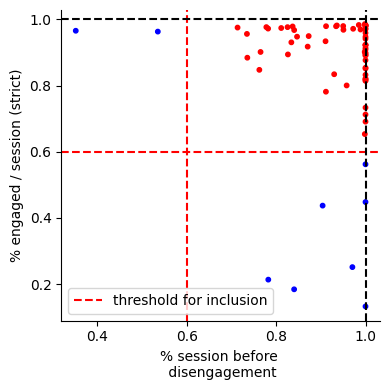

In [70]:
# Plot performance metrics + filtering
all_stats, all_label_stats = plot_performance_hist(all_session_performance_summary)
plot_performance_filtering(all_stats, all_label_stats, thresh_perc_engaged, thresh_dur_engaged)

In [ ]:
session = cache.get_behavior_session(valid_session_ids[0])

In [77]:
ecephys_valid_session_ids = ecephys_session_table_final2.loc[ecephys_session_table_final2.behavior_session_id.isin(valid_session_ids), ['behavior_session_id','ecephys_session_id']]
ecephys_valid_session_ids
ecephys_valid_session_ids.to_csv('/root/capsule/resources/good_session_ids.csv')

In [ ]:
# valid_sessions, list_error = extract_relevant_sessions(cache, valid_session_ids, verbose=True)

Start loading session 0/9.
Start loading session 1/9.
Start loading session 2/9.
Start loading session 3/9.
Start loading session 4/9.
Start loading session 5/9.
Start loading session 6/9.
Start loading session 7/9.
Start loading session 8/9.


Check mice also for initial / intermediate unengaged period.

--> Plot heatmap for the sessions (engaged / disengaged in two different colors)

#### Plot discarded sessions

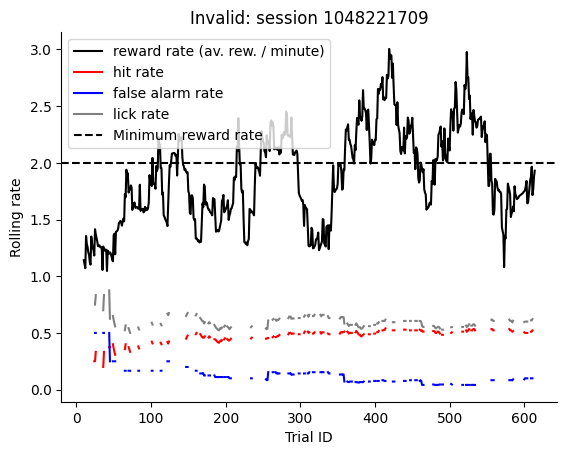

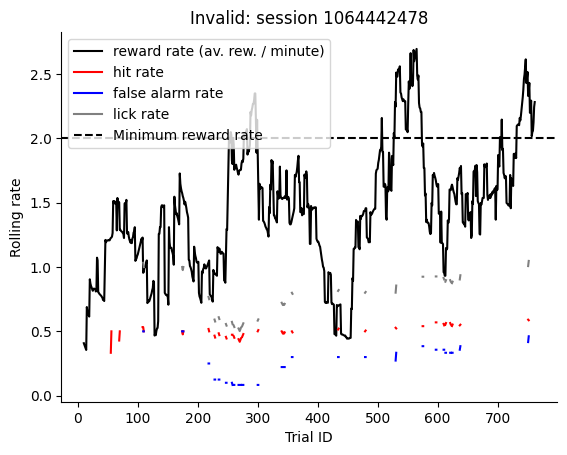

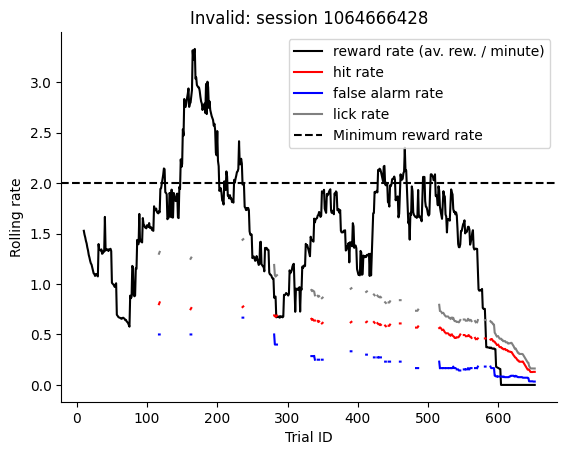

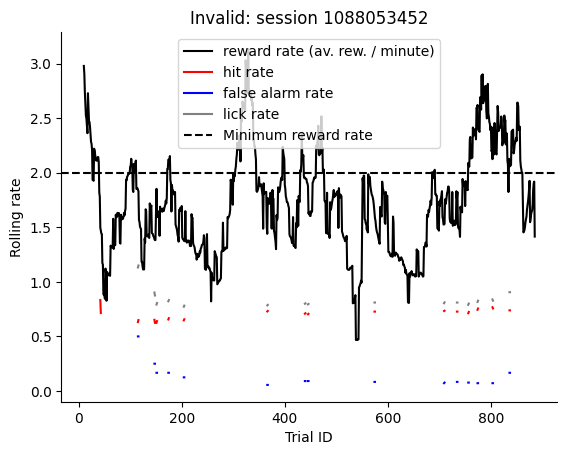

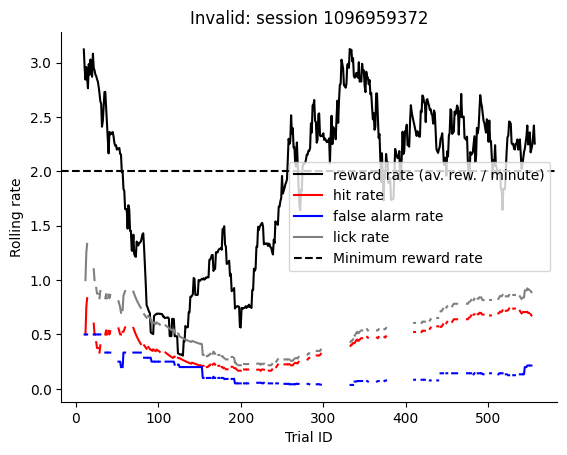

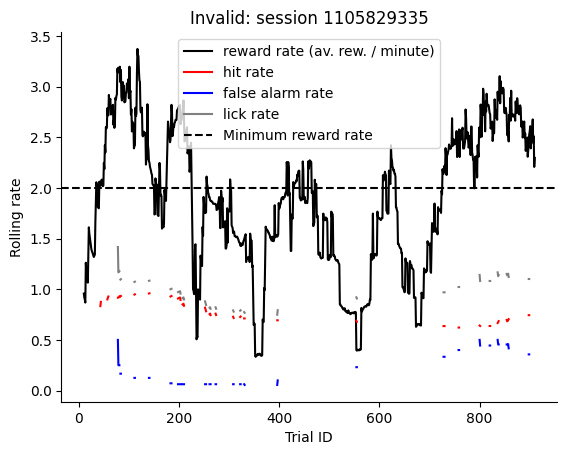

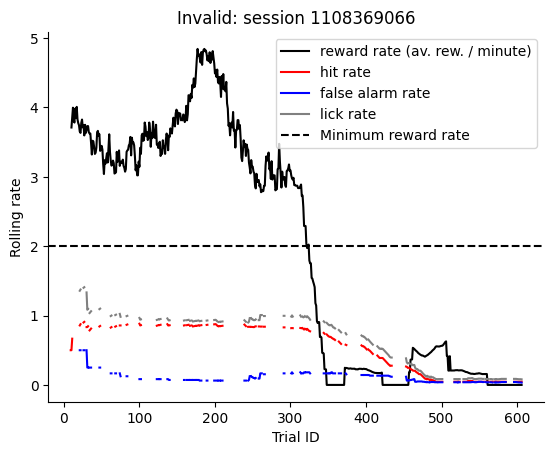

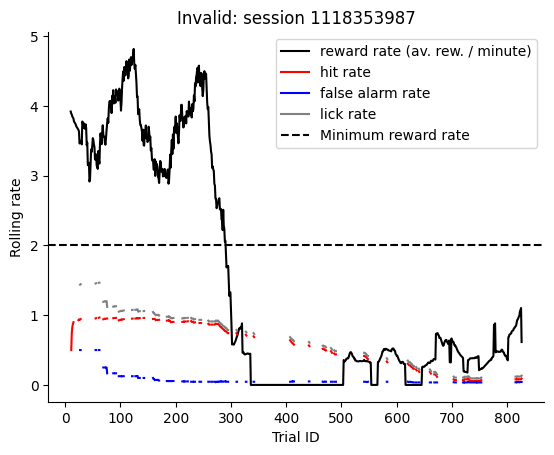

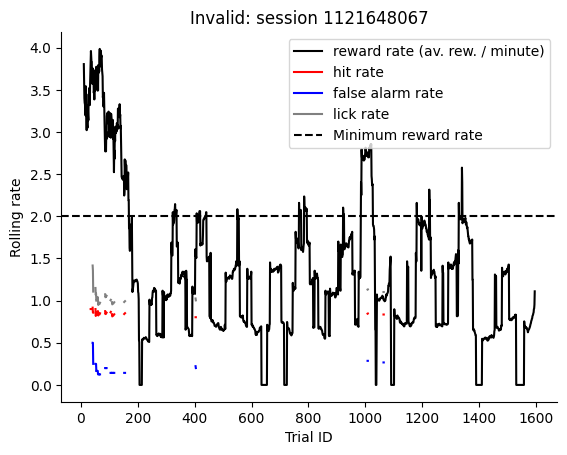

In [82]:
## Plot discarded sessions
all_session_id = ecephys_session_table_final2.behavior_session_id.unique()

for sess_id in all_session_id:
    if sess_id not in valid_session_ids:
        session = cache.get_behavior_session(sess_id)
        rolling_performance = session.get_rolling_performance_df()
        plot_single_session_performance(rolling_performance, title=f'Invalid: session {sess_id}')

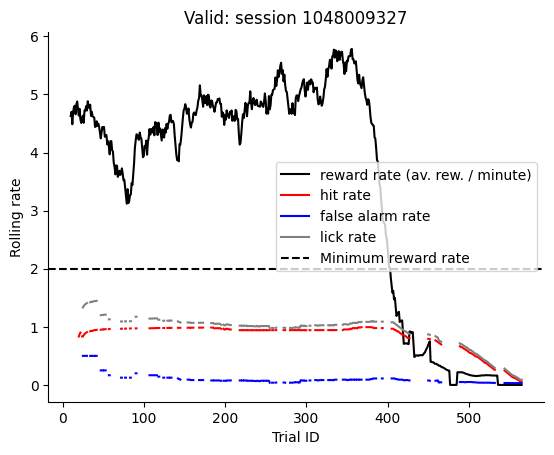

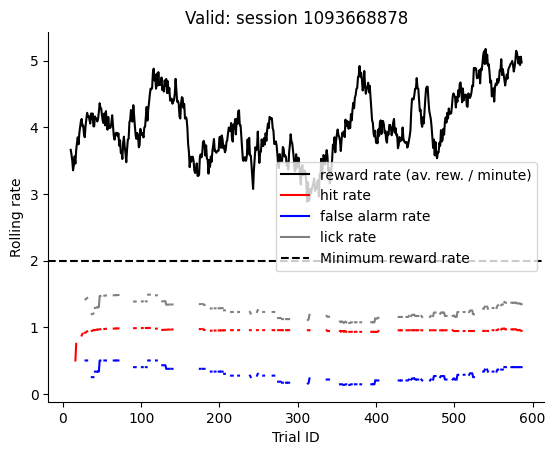

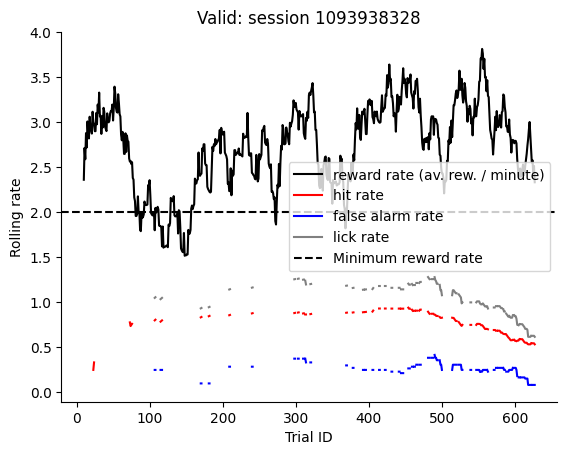

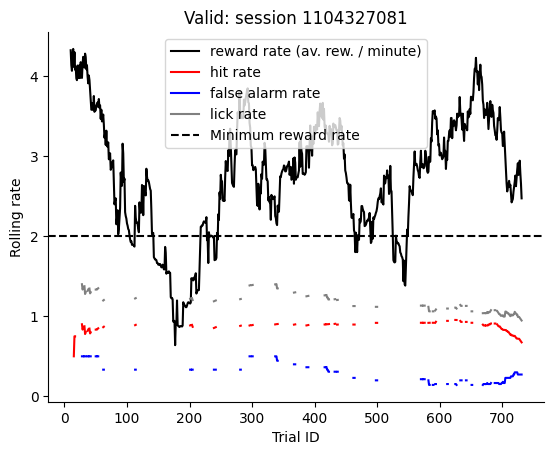

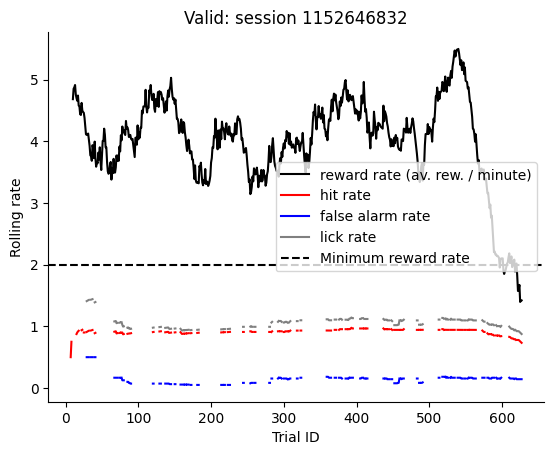

In [83]:
num_example_sessions = 5
example_valid_sessions = np.random.choice(valid_session_ids, num_example_sessions)
for sess_id in all_session_id:
    if sess_id in example_valid_sessions:
        session = cache.get_behavior_session(sess_id)
        rolling_performance = session.get_rolling_performance_df()
        plot_single_session_performance(rolling_performance, title=f'Valid: session {sess_id}')